In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv('Data/All_Labelled.csv')

print(df)

       src_port  dst_port  protocol  ip_version  vlan_id  tunnel_id  \
0         56343       443         6           4        0          0   
1             0         0         2           4        0          0   
2         43586       443         6           4        0          0   
3          5353      5353        17           4        0          0   
4             0         0         1           4        0          0   
...         ...       ...       ...         ...      ...        ...   
74338     53371        53        17           4        0          0   
74339     38524        53        17           4        0          0   
74340     46482       443         6           4        0          0   
74341     59176        53        17           4        0          0   
74342     54414       443         6           4        0          0   

       bidirectional_first_seen_ms  bidirectional_last_seen_ms  \
0                     1.666040e+12                1.666040e+12   
1              

In [3]:
print(df.info())
print(df.describe())
print(df['Label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74343 entries, 0 to 74342
Data columns (total 79 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   src_port                      74343 non-null  int64  
 1   dst_port                      74343 non-null  int64  
 2   protocol                      74343 non-null  int64  
 3   ip_version                    74343 non-null  int64  
 4   vlan_id                       74343 non-null  int64  
 5   tunnel_id                     74343 non-null  int64  
 6   bidirectional_first_seen_ms   74343 non-null  float64
 7   bidirectional_last_seen_ms    74343 non-null  float64
 8   bidirectional_duration_ms     74343 non-null  int64  
 9   bidirectional_packets         74343 non-null  int64  
 10  bidirectional_bytes           74343 non-null  int64  
 11  src2dst_first_seen_ms         74343 non-null  float64
 12  src2dst_last_seen_ms          74343 non-null  float64
 13  s

In [4]:
# Eksik değer kontrolü
missing = df.isnull().sum().sort_values(ascending=False)
print(missing[missing > 0])

# Sıfır port kontrolü
print(df[(df['src_port'] == 0) | (df['dst_port'] == 0)].shape)


user_agent            218
content_type          218
server_fingerprint      7
dtype: int64
(2191, 79)


In [5]:
df_encoded = df.copy()
cat_cols = df_encoded.select_dtypes(include='object').columns

# NaN'leri "unknown" ile doldur ve label encode et
for col in cat_cols:
    df_encoded[col] = df_encoded[col].fillna("unknown")
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])


In [6]:
# Eksik verileri kontrol et
missing_after_fill = df_encoded.isnull().sum()

# Sıfırdan büyük olanları yazdır (hala eksik olanlar)
missing_columns = missing_after_fill[missing_after_fill > 0]

if missing_columns.empty:
    print("✅ Tüm eksik veriler başarıyla doldurulmuş. Veri setinde eksik değer kalmadı.")
else:
    print("⚠️ Hala eksik değer içeren sütunlar:")
    print(missing_columns)


✅ Tüm eksik veriler başarıyla doldurulmuş. Veri setinde eksik değer kalmadı.


In [7]:
# Özellik ve etiket ayrımı
X = df_encoded.drop(columns=['Label'])
y = df_encoded['Label']


In [8]:
# Normalizasyon
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


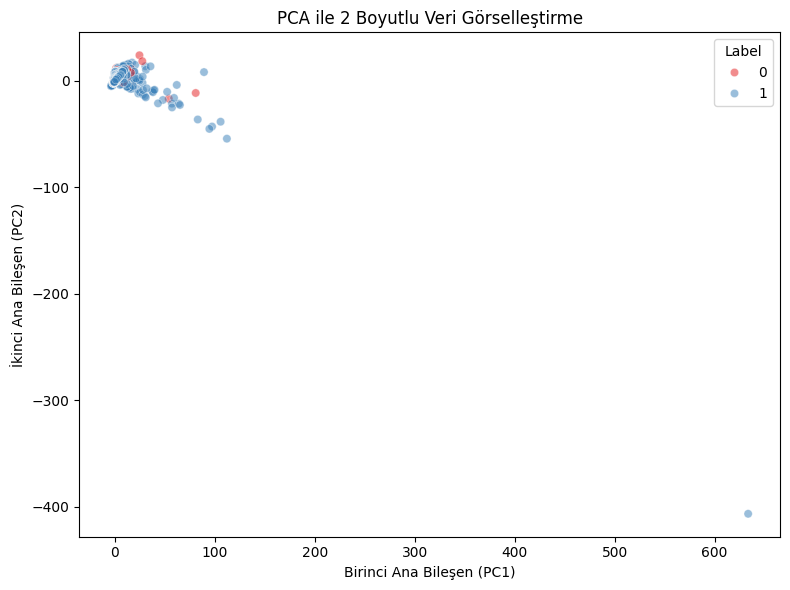

In [9]:
# PCA uygulama (2 bileşen)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# DataFrame'e dönüştür
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Label'] = y

# Görselleştirme
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Label', palette='Set1', alpha=0.5)
plt.title("PCA ile 2 Boyutlu Veri Görselleştirme")
plt.xlabel("Birinci Ana Bileşen (PC1)")
plt.ylabel("İkinci Ana Bileşen (PC2)")
plt.tight_layout()
plt.show()


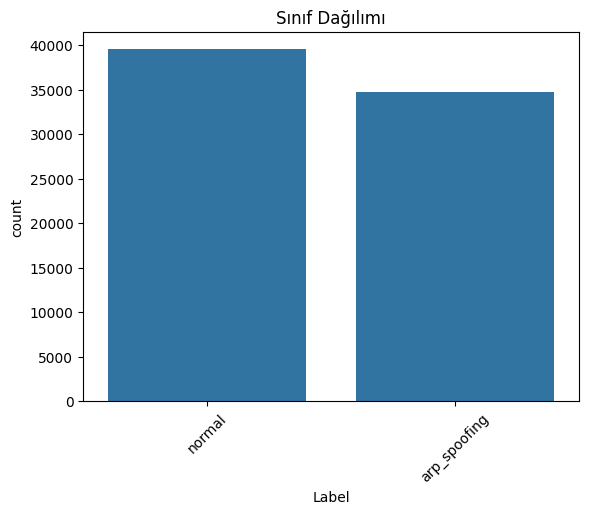

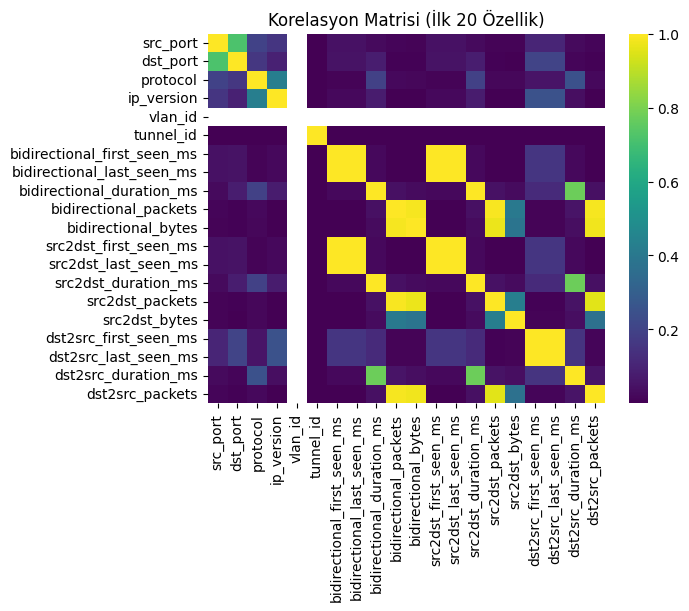

In [10]:
# Sınıf dağılımı
sns.countplot(x=df['Label'])
plt.title("Sınıf Dağılımı")
plt.xticks(rotation=45)
plt.show()

# Korelasyon Matrisi
corr = df_encoded.corr().abs()
sns.heatmap(corr.iloc[:20, :20], cmap='viridis')
plt.title("Korelasyon Matrisi (İlk 20 Özellik)")
plt.show()


In [11]:
# 1. Kategorik sütunlar zaten encode edilmiş olmalı (önceki adımda yapıldı)
# 2. Özellik ve etiket ayrımı
X = df_encoded.drop(columns=['Label'])
y = df_encoded['Label']

# 3. Eğitim ve test verisine ayır (SMOTE sadece eğitim verisine uygulanır!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Ölçekleme (LSTM vs için de kullanılır)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
# SMOTE uygulaması
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Sonuç kontrolü
print("Orijinal eğitim veri dağılımı:\n", y_train.value_counts())
print("SMOTE sonrası eğitim veri dağılımı:\n", pd.Series(y_train_smote).value_counts())


Orijinal eğitim veri dağılımı:
 Label
1    31641
0    27833
Name: count, dtype: int64
SMOTE sonrası eğitim veri dağılımı:
 Label
0    31641
1    31641
Name: count, dtype: int64


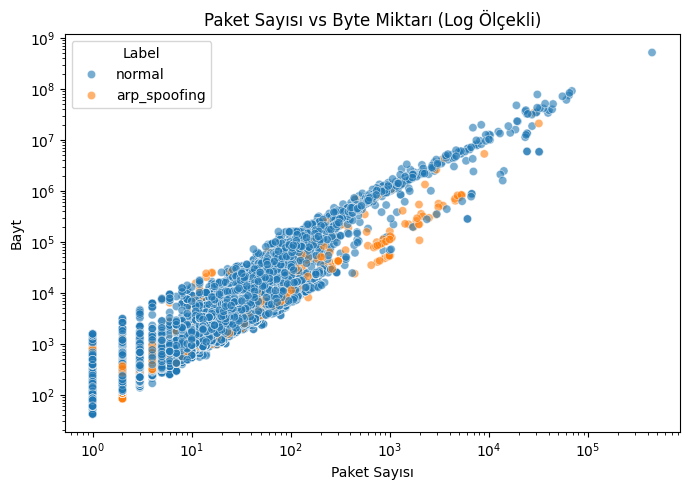

In [13]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x="bidirectional_packets", y="bidirectional_bytes", hue="Label", alpha=0.6)
plt.xscale("log")
plt.yscale("log")
plt.title("Paket Sayısı vs Byte Miktarı (Log Ölçekli)")
plt.xlabel("Paket Sayısı")
plt.ylabel("Bayt")
plt.tight_layout()
plt.show()


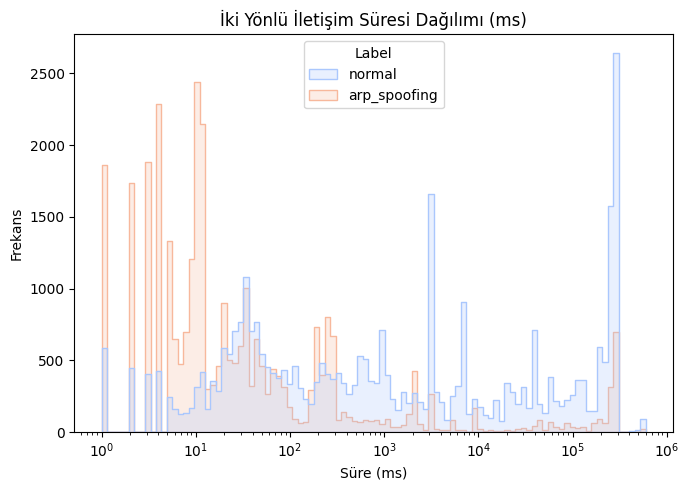

In [14]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df, x="bidirectional_duration_ms", hue="Label", bins=100, log_scale=True, element="step", palette="coolwarm")
plt.title("İki Yönlü İletişim Süresi Dağılımı (ms)")
plt.xlabel("Süre (ms)")
plt.ylabel("Frekans")
plt.tight_layout()
plt.show()


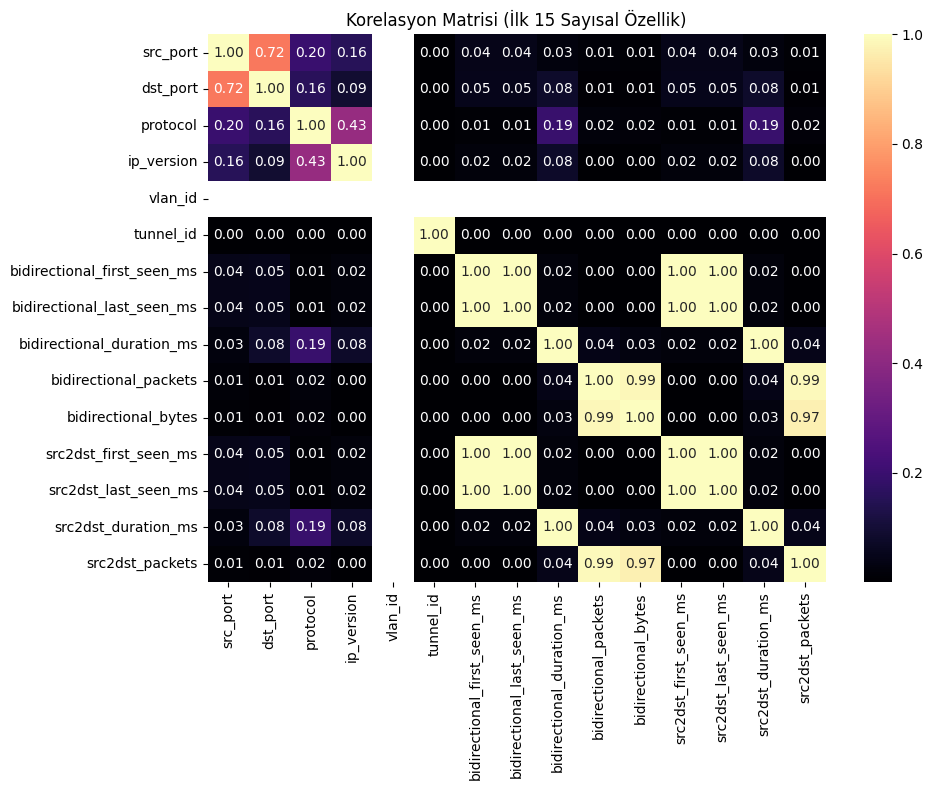

In [15]:
plt.figure(figsize=(10, 8))
corr_matrix = df.select_dtypes(include=['int64', 'float64']).corr().abs().iloc[:15, :15]
sns.heatmap(corr_matrix, cmap="magma", annot=True, fmt=".2f")
plt.title("Korelasyon Matrisi (İlk 15 Sayısal Özellik)")
plt.tight_layout()
plt.show()


In [16]:
# Model 1: Decision Tree
dt_params = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=dt_params,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)
dt_search.fit(X_train_scaled, y_train)
dt_best = dt_search.best_estimator_
dt_pred = dt_best.predict(X_test_scaled)


# Model 2: Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=rf_params,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)
rf_search.fit(X_train_scaled, y_train)
rf_best = rf_search.best_estimator_
rf_pred = rf_best.predict(X_test_scaled)

# Model 3: XGBoost
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_distributions=xgb_params,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)
xgb_search.fit(X_train_scaled, y_train)
xgb_best = xgb_search.best_estimator_
xgb_pred = xgb_best.predict(X_test_scaled)


# Model 4: LSTM
# LSTM için en fazla kullanılabilecek feature sayısı
# reshape input
max_features = min(100, X_train_scaled.shape[1])
X_lstm_train = X_train_scaled[:, :max_features].reshape((-1, 1, max_features))
X_lstm_test = X_test_scaled[:, :max_features].reshape((-1, 1, max_features))
# ✅ SORUN ÇÖZÜMÜ: pandas Series'i numpy array'e çevir
y_lstm_train = np.array(y_train)
y_lstm_test = np.array(y_test)

def manual_hyperparameter_tuning():
    print("\n=== Manuel Hyperparameter Tuning ===")
    
    # Parametre kombinasyonları
    param_combinations = [
        {'units': 32, 'dropout': 0.2, 'lr': 0.001, 'epochs': 5, 'batch_size': 64},
        {'units': 64, 'dropout': 0.3, 'lr': 0.001, 'epochs': 5, 'batch_size': 64},
        {'units': 128, 'dropout': 0.5, 'lr': 0.0005, 'epochs': 5, 'batch_size': 128},
        {'units': 64, 'dropout': 0.2, 'lr': 0.001, 'epochs': 10, 'batch_size': 128},
        {'units': 32, 'dropout': 0.3, 'lr': 0.0005, 'epochs': 5, 'batch_size': 64}
    ]
    
    best_score = 0
    best_params = None
    best_model = None
    
    # 2-fold cross validation
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    
    for i, params in enumerate(param_combinations):
        print(f"\nTest ediliyor {i+1}/{len(param_combinations)}: {params}")
        
        cv_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X_lstm_train, y_lstm_train)):
            X_cv_train, X_cv_val = X_lstm_train[train_idx], X_lstm_train[val_idx]
            y_cv_train, y_cv_val = y_lstm_train[train_idx], y_lstm_train[val_idx]
            
            # Model oluştur
            model = Sequential([
                LSTM(params['units'], input_shape=(1, max_features)),
                Dropout(params['dropout']),
                Dense(1, activation='sigmoid')
            ])
            
            model.compile(
                optimizer=Adam(learning_rate=params['lr']),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            
            # Eğit
            model.fit(
                X_cv_train, y_cv_train,
                epochs=params['epochs'],
                batch_size=params['batch_size'],
                verbose=0,
                validation_split=0.1
            )
            
            # Değerlendir
            y_pred = (model.predict(X_cv_val, verbose=0) > 0.5).astype(int).flatten()
            score = f1_score(y_cv_val, y_pred)
            cv_scores.append(score)
        
        # Ortalama skor
        avg_score = np.mean(cv_scores)
        print(f"  CV F1 Score: {avg_score:.4f} (±{np.std(cv_scores):.4f})")
        
        if avg_score > best_score:
            best_score = avg_score
            best_params = params
            
            # En iyi modeli tekrar eğit
            best_model = Sequential([
                LSTM(params['units'], input_shape=(1, max_features)),
                Dropout(params['dropout']),
                Dense(1, activation='sigmoid')
            ])
            
            best_model.compile(
                optimizer=Adam(learning_rate=params['lr']),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            
            best_model.fit(
                X_lstm_train, y_lstm_train,
                epochs=params['epochs'],
                batch_size=params['batch_size'],
                verbose=0,
                validation_split=0.1
            )
    
    print(f"\n🏆 En iyi parametreler: {best_params}")
    print(f"🏆 En iyi CV F1 Score: {best_score:.4f}")
    
    # Test seti ile tahmin
    final_predictions = best_model.predict(X_lstm_test, verbose=0)
    lstm_pred = (final_predictions > 0.5).astype(int).flatten()
    
    test_f1 = f1_score(y_lstm_test, lstm_pred)
    print(f"🎯 Test F1 Score: {test_f1:.4f}")
    
    return lstm_pred, best_model, best_params

# Fonksiyonu çalıştır
lstm_pred, lstm_best_model, lstm_best_params = manual_hyperparameter_tuning()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
# Değerlendirme fonksiyonu
def evaluate_model(name, y_true, y_pred):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_pred)
    }

# Sonuçları topla
results = [
    evaluate_model("Decision Tree", y_test, dt_pred),
    evaluate_model("Random Forest", y_test, rf_pred),
    evaluate_model("XGBoost", y_test, xgb_pred),
    evaluate_model("LSTM", y_test, lstm_pred)
]

# Tabloya dök
results_df = pd.DataFrame(results)
print(results_df)

           Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Decision Tree  0.955680   0.960966  0.955499  0.958225  0.955692
1  Random Forest  0.967382   0.960665  0.978761  0.969629  0.966604
2        XGBoost  0.969332   0.964019  0.978887  0.971396  0.968679
3           LSTM  0.916471   0.921385  0.921618  0.921502  0.916119


In [18]:
# SMOTELU VERSION
# Model 1: Decision Tree
dt_params = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=dt_params,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)
dt_search.fit(X_train_smote, y_train_smote)
dt_best = dt_search.best_estimator_
dt_pred = dt_best.predict(X_test_scaled)


# Model 2: Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=rf_params,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)
rf_search.fit(X_train_smote, y_train_smote)
rf_best = rf_search.best_estimator_
rf_pred = rf_best.predict(X_test_scaled)

# Model 3: XGBoost
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_distributions=xgb_params,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)
xgb_search.fit(X_train_smote, y_train_smote)
xgb_best = xgb_search.best_estimator_
xgb_pred = xgb_best.predict(X_test_scaled)


# Model 4: LSTM
# LSTM için en fazla kullanılabilecek feature sayısı
# reshape input
max_features = min(100, X_train_scaled.shape[1])
X_lstm_train = X_train_smote[:, :max_features].reshape((-1, 1, max_features))
X_lstm_test = X_test_scaled[:, :max_features].reshape((-1, 1, max_features))
# ✅ SORUN ÇÖZÜMÜ: pandas Series'i numpy array'e çevir
y_lstm_train = np.array(y_train_smote)
y_lstm_test = np.array(y_test)

def manual_hyperparameter_tuning():
    print("\n=== Manuel Hyperparameter Tuning ===")
    
    # Parametre kombinasyonları
    param_combinations = [
        {'units': 32, 'dropout': 0.2, 'lr': 0.001, 'epochs': 5, 'batch_size': 64},
        {'units': 64, 'dropout': 0.3, 'lr': 0.001, 'epochs': 5, 'batch_size': 64},
        {'units': 128, 'dropout': 0.5, 'lr': 0.0005, 'epochs': 5, 'batch_size': 128},
        {'units': 64, 'dropout': 0.2, 'lr': 0.001, 'epochs': 10, 'batch_size': 128},
        {'units': 32, 'dropout': 0.3, 'lr': 0.0005, 'epochs': 5, 'batch_size': 64}
    ]
    
    best_score = 0
    best_params = None
    best_model = None
    
    # 2-fold cross validation
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    
    for i, params in enumerate(param_combinations):
        print(f"\nTest ediliyor {i+1}/{len(param_combinations)}: {params}")
        
        cv_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X_lstm_train, y_lstm_train)):
            X_cv_train, X_cv_val = X_lstm_train[train_idx], X_lstm_train[val_idx]
            y_cv_train, y_cv_val = y_lstm_train[train_idx], y_lstm_train[val_idx]
            
            # Model oluştur
            model = Sequential([
                LSTM(params['units'], input_shape=(1, max_features)),
                Dropout(params['dropout']),
                Dense(1, activation='sigmoid')
            ])
            
            model.compile(
                optimizer=Adam(learning_rate=params['lr']),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            
            # Eğit
            model.fit(
                X_cv_train, y_cv_train,
                epochs=params['epochs'],
                batch_size=params['batch_size'],
                verbose=0,
                validation_split=0.1
            )
            
            # Değerlendir
            y_pred = (model.predict(X_cv_val, verbose=0) > 0.5).astype(int).flatten()
            score = f1_score(y_cv_val, y_pred)
            cv_scores.append(score)
        
        # Ortalama skor
        avg_score = np.mean(cv_scores)
        print(f"  CV F1 Score: {avg_score:.4f} (±{np.std(cv_scores):.4f})")
        
        if avg_score > best_score:
            best_score = avg_score
            best_params = params
            
            # En iyi modeli tekrar eğit
            best_model = Sequential([
                LSTM(params['units'], input_shape=(1, max_features)),
                Dropout(params['dropout']),
                Dense(1, activation='sigmoid')
            ])
            
            best_model.compile(
                optimizer=Adam(learning_rate=params['lr']),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            
            best_model.fit(
                X_lstm_train, y_lstm_train,
                epochs=params['epochs'],
                batch_size=params['batch_size'],
                verbose=0,
                validation_split=0.1
            )
    
    print(f"\n🏆 En iyi parametreler: {best_params}")
    print(f"🏆 En iyi CV F1 Score: {best_score:.4f}")
    
    # Test seti ile tahmin
    final_predictions = best_model.predict(X_lstm_test, verbose=0)
    lstm_pred = (final_predictions > 0.5).astype(int).flatten()
    
    test_f1 = f1_score(y_lstm_test, lstm_pred)
    print(f"🎯 Test F1 Score: {test_f1:.4f}")
    
    return lstm_pred, best_model, best_params

# Fonksiyonu çalıştır
lstm_pred, lstm_best_model, lstm_best_params = manual_hyperparameter_tuning()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\fatmu\OneDrive\Masaüstü\virtualEnvs\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:06:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Manuel Hyperparameter Tuning ===

Test ediliyor 1/5: {'units': 32, 'dropout': 0.2, 'lr': 0.001, 'epochs': 5, 'batch_size': 64}


c:\Users\fatmu\OneDrive\Masaüstü\virtualEnvs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\fatmu\OneDrive\Masaüstü\virtualEnvs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  CV F1 Score: 0.9044 (±0.0003)


c:\Users\fatmu\OneDrive\Masaüstü\virtualEnvs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Test ediliyor 2/5: {'units': 64, 'dropout': 0.3, 'lr': 0.001, 'epochs': 5, 'batch_size': 64}


c:\Users\fatmu\OneDrive\Masaüstü\virtualEnvs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\fatmu\OneDrive\Masaüstü\virtualEnvs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  CV F1 Score: 0.9034 (±0.0026)

Test ediliyor 3/5: {'units': 128, 'dropout': 0.5, 'lr': 0.0005, 'epochs': 5, 'batch_size': 128}


c:\Users\fatmu\OneDrive\Masaüstü\virtualEnvs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\fatmu\OneDrive\Masaüstü\virtualEnvs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  CV F1 Score: 0.8897 (±0.0014)

Test ediliyor 4/5: {'units': 64, 'dropout': 0.2, 'lr': 0.001, 'epochs': 10, 'batch_size': 128}


c:\Users\fatmu\OneDrive\Masaüstü\virtualEnvs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\fatmu\OneDrive\Masaüstü\virtualEnvs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  CV F1 Score: 0.9075 (±0.0008)


c:\Users\fatmu\OneDrive\Masaüstü\virtualEnvs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Test ediliyor 5/5: {'units': 32, 'dropout': 0.3, 'lr': 0.0005, 'epochs': 5, 'batch_size': 64}


c:\Users\fatmu\OneDrive\Masaüstü\virtualEnvs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\fatmu\OneDrive\Masaüstü\virtualEnvs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  CV F1 Score: 0.8949 (±0.0026)

🏆 En iyi parametreler: {'units': 64, 'dropout': 0.2, 'lr': 0.001, 'epochs': 10, 'batch_size': 128}
🏆 En iyi CV F1 Score: 0.9075
🎯 Test F1 Score: 0.9223


In [20]:
# Değerlendirme fonksiyonu
def evaluate_model(name, y_true, y_pred):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_pred)
    }

# Sonuçları topla
results = [
    evaluate_model("Decision Tree SMOTED", y_test, dt_pred),
    evaluate_model("Random Forest SMOTED", y_test, rf_pred),
    evaluate_model("XGBoost SMOTED", y_test, xgb_pred),
    evaluate_model("LSTM SMOTED", y_test, lstm_pred)
]

# Tabloya dök
results_df = pd.DataFrame(results)
print(results_df)

                  Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Decision Tree SMOTED  0.955007   0.958233  0.957143  0.957688  0.954861
1  Random Forest SMOTED  0.967651   0.961601  0.978255  0.969856  0.966926
2        XGBoost SMOTED  0.963481   0.952797  0.979899  0.966158  0.962359
3           LSTM SMOTED  0.917681   0.925860  0.918837  0.922335  0.917602


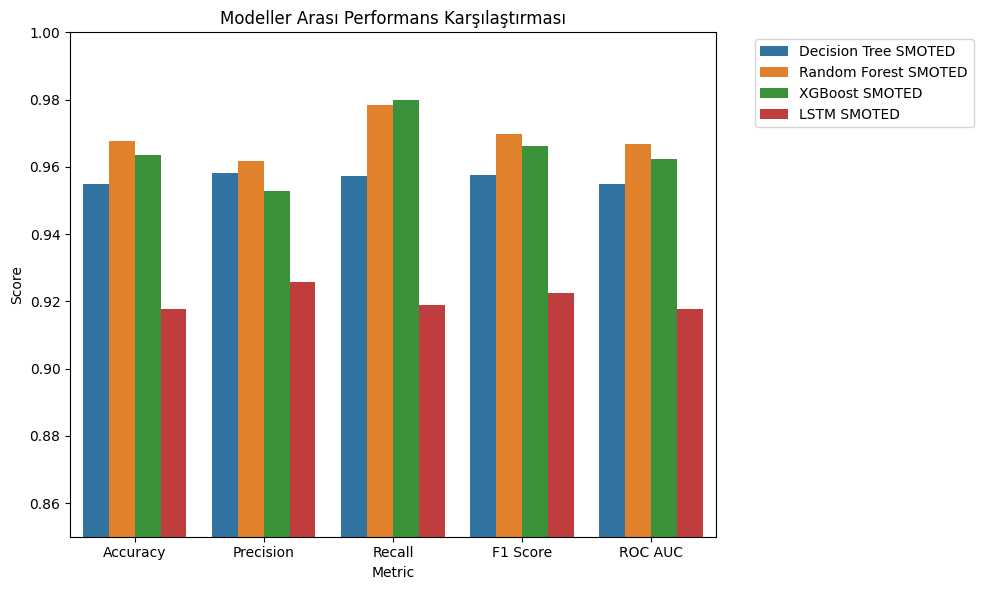

In [21]:
# Tablon varsa: results_df
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]

plt.figure(figsize=(10, 6))
results_melted = results_df.melt(id_vars=["Model"], value_vars=metrics, var_name="Metric", value_name="Score")

sns.barplot(data=results_melted, x="Metric", y="Score", hue="Model")
plt.title("Modeller Arası Performans Karşılaştırması")
plt.ylim(0.85, 1.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


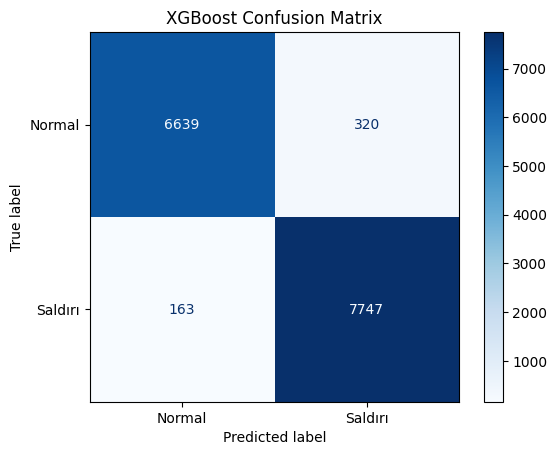

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Her model için ayrı çizim (örnek: XGBoost)
cm = confusion_matrix(y_test, xgb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Saldırı"])
disp.plot(cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.show()

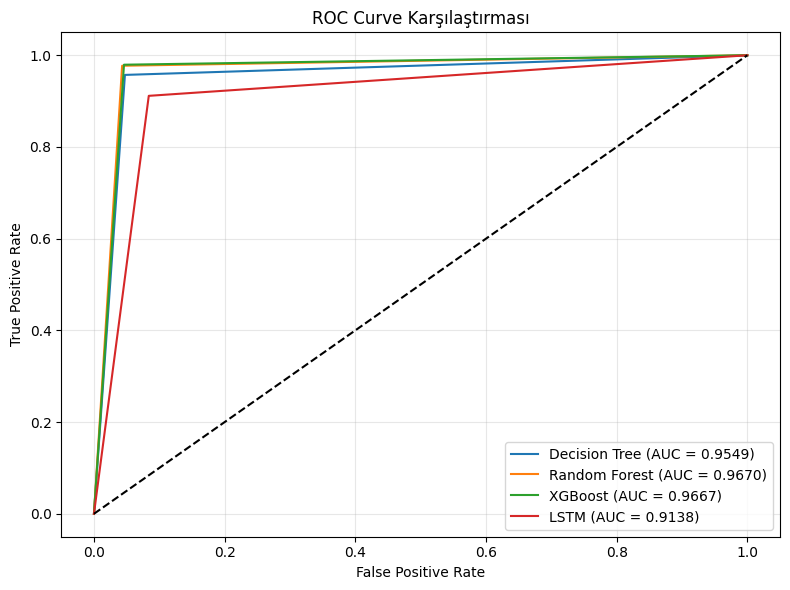

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

for name, y_pred in zip(
    ["Decision Tree", "Random Forest", "XGBoost", "LSTM"],
    [dt_pred, rf_pred, xgb_pred, lstm_pred]
):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Karşılaştırması")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


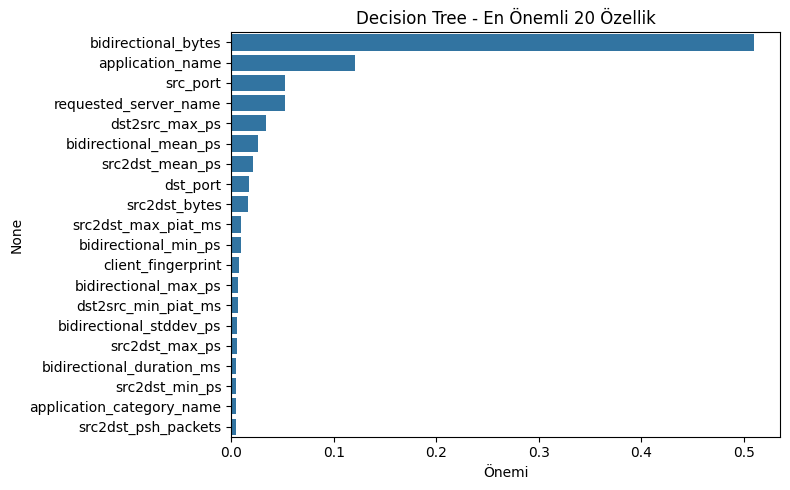

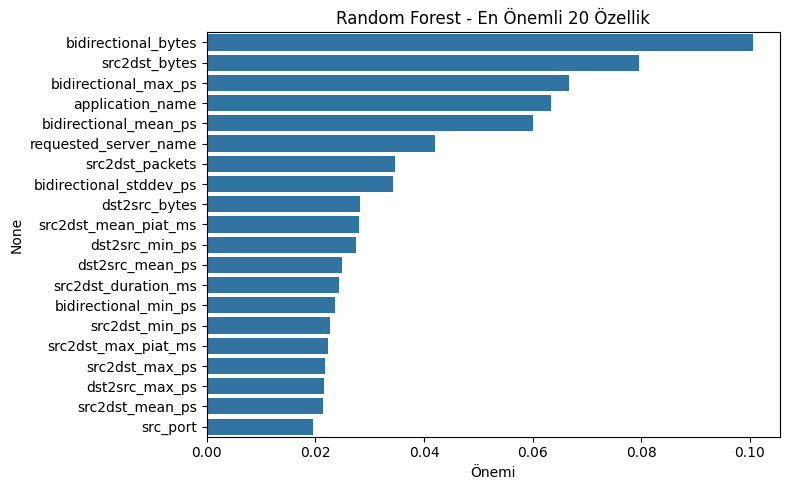

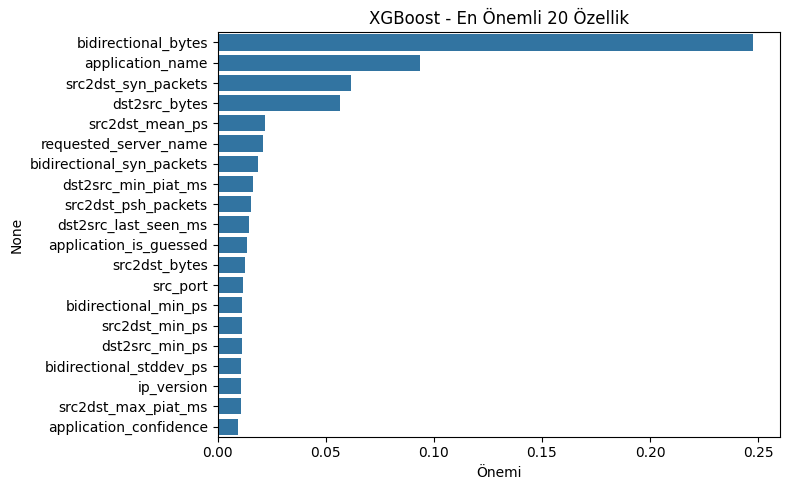

In [23]:
# Orijinal X sütunlarının isimlerini al (ölçeklenmeden önceki)
feature_names = X_train.columns

# 1. Decision Tree Feature Importance
dt_importance = pd.Series(dt_best.feature_importances_, index=feature_names).sort_values(ascending=False).head(20)
plt.figure(figsize=(8, 5))
sns.barplot(x=dt_importance.values, y=dt_importance.index)
plt.title("Decision Tree - En Önemli 20 Özellik")
plt.xlabel("Önemi")
plt.tight_layout()
plt.show()

# 2. Random Forest Feature Importance
rf_importance = pd.Series(rf_best.feature_importances_, index=feature_names).sort_values(ascending=False).head(20)
plt.figure(figsize=(8, 5))
sns.barplot(x=rf_importance.values, y=rf_importance.index)
plt.title("Random Forest - En Önemli 20 Özellik")
plt.xlabel("Önemi")
plt.tight_layout()
plt.show()

# 3. XGBoost Feature Importance
xgb_importance = pd.Series(xgb_best.feature_importances_, index=feature_names).sort_values(ascending=False).head(20)
plt.figure(figsize=(8, 5))
sns.barplot(x=xgb_importance.values, y=xgb_importance.index)
plt.title("XGBoost - En Önemli 20 Özellik")
plt.xlabel("Önemi")
plt.tight_layout()
plt.show()


In [24]:
# Eğer feature isimlerin varsa, array'leri tekrar DataFrame'e çevir
X_train_smote_df = pd.DataFrame(X_train_smote, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# En önemli 10 özelliği al
top_10_features = xgb_importance.head(10).index.tolist()

# Eğitim ve test verilerini sadece bu 10 özellik ile filtrele
X_train_top10 = X_train_smote_df[top_10_features]
X_test_top10 = X_test_scaled_df[top_10_features]

# Yeni XGBoost modeli ile eğit
xgb_top10 = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_top10.fit(X_train_top10, y_train_smote)

# Tahmin yap
xgb_top10_pred = xgb_top10.predict(X_test_top10)


c:\Users\fatmu\OneDrive\Masaüstü\virtualEnvs\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:14:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [25]:
result_xgb_top10 = evaluate_model("XGBoost SMOTED with Top 10 features", y_test, xgb_top10_pred)
result_xgb_top10_df = pd.DataFrame([result_xgb_top10])
print(result_xgb_top10_df.to_string(index=False))

                              Model  Accuracy  Precision   Recall  F1 Score  ROC AUC
XGBoost SMOTED with Top 10 features  0.949156   0.943027 0.962579  0.952703 0.948239
